##Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%run /content/drive/MyDrive/NLP/preprocessing.ipynb

In [3]:
!pip install -U textblob

In [4]:
!pip install advertools

In [66]:
%matplotlib inline
import os
import re
import nltk
import json
import gensim
import dateutil
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import advertools as adv
from scipy import sparse
from functools import reduce
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from IPython.display import Image
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

from nltk.corpus import stopwords
from googletrans import Translator
from sklearn.metrics import r2_score
sns.set(style="ticks", color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

random_state=2022

##Read File

In [6]:
df=pd.read_csv('/content/drive/MyDrive/NLP/final_dataset.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,14,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


##Drop the columns

In [7]:
dropped = ['profile_name', 'profile_image_link', 'biography','id','thumbnails', 'url', 'location','image_url','external_url','media_type','business_email','is_verified']
data = df.drop(dropped,axis=1)
data = data[data['account'].notna()]
data

,account,caption,following,likes,posts_count,followers,datetime,comments
10,chelsea_bridge_clinic,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,1612780000000.0,0.0
11,chelsea_bridge_clinic,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,1611240000000.0,0.0
12,numberoneedin,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,1645290000000.0,2.0
13,numberoneedin,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,1643660000000.0,1.0
14,numberoneedin,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,1643220000000.0,1.0
...,...,...,...,...,...,...,...,...
74544,thesavoylondon,"Alongside hospitality, the performing arts hav...",599.0,4079,1933.0,167394.0,1610730000000.0,67
74545,thesavoylondon,This! Isn’t this what we are looking forward ...,599.0,1621,1933.0,167394.0,1610550000000.0,34
74546,thesavoylondon,"For those of you who are missing London town, ...",599.0,1548,1933.0,167394.0,1610370000000.0,28
74547,thesavoylondon,While we’re closed we’re going to try and keep...,599.0,2637,1933.0,167394.0,1609940000000.0,68


In [8]:
rm_list = []

for i in range(data.shape[0]):
    if type(data["datetime"].values[i]) != float:
        rm_list.append(i)

len(rm_list)
for i in rm_list:
    data.drop([i], axis=0, inplace=True)

In [9]:
#Converting the columns into the float datatype
a=['following','likes','posts_count','followers','comments']
for i in a:
  data[i]= data[i].astype(str).astype(float)
data

,account,caption,following,likes,posts_count,followers,datetime,comments
10,chelsea_bridge_clinic,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,1612780000000.0,0.0
11,chelsea_bridge_clinic,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,1611240000000.0,0.0
12,numberoneedin,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,1645290000000.0,2.0
13,numberoneedin,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,1643660000000.0,1.0
14,numberoneedin,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,1643220000000.0,1.0
...,...,...,...,...,...,...,...,...
74544,thesavoylondon,"Alongside hospitality, the performing arts hav...",599.0,4079.0,1933.0,167394.0,1610730000000.0,67.0
74545,thesavoylondon,This! Isn’t this what we are looking forward ...,599.0,1621.0,1933.0,167394.0,1610550000000.0,34.0
74546,thesavoylondon,"For those of you who are missing London town, ...",599.0,1548.0,1933.0,167394.0,1610370000000.0,28.0
74547,thesavoylondon,While we’re closed we’re going to try and keep...,599.0,2637.0,1933.0,167394.0,1609940000000.0,68.0


#Numerical Features

###Conversion of date to timestamp

In [10]:
import datetime
def timeStampConversion(x):
    return datetime.datetime.fromtimestamp(int(x)/1000)

data['datetime'] = pd.to_numeric(data['datetime'], downcast="float")
data['datetime'] = data['datetime'].apply(lambda x: timeStampConversion(x)) 
data["datetime"] = pd.to_datetime(data["datetime"])

In [11]:
data['Dow'] = data['datetime'].dt.weekday
data['Hod']= data['datetime'].dt.hour
data['Date']= data['datetime'].dt.date

In [12]:
data

,account,caption,following,likes,posts_count,followers,datetime,comments,Dow,Hod,Date
10,chelsea_bridge_clinic,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,2021-02-08 10:26:51.520,0.0,0,10,2021-02-08
11,chelsea_bridge_clinic,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,2021-01-21 14:40:46.592,0.0,3,14,2021-01-21
12,numberoneedin,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,2022-02-19 17:01:01.824,2.0,5,17,2022-02-19
13,numberoneedin,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,2022-01-31 20:14:10.432,1.0,0,20,2022-01-31
14,numberoneedin,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,2022-01-26 18:00:41.728,1.0,2,18,2022-01-26
...,...,...,...,...,...,...,...,...,...,...,...
74544,thesavoylondon,"Alongside hospitality, the performing arts hav...",599.0,4079.0,1933.0,167394.0,2021-01-15 17:00:45.440,67.0,4,17,2021-01-15
74545,thesavoylondon,This! Isn’t this what we are looking forward ...,599.0,1621.0,1933.0,167394.0,2021-01-13 14:59:12.512,34.0,2,14,2021-01-13
74546,thesavoylondon,"For those of you who are missing London town, ...",599.0,1548.0,1933.0,167394.0,2021-01-11 12:59:50.656,28.0,0,12,2021-01-11
74547,thesavoylondon,While we’re closed we’re going to try and keep...,599.0,2637.0,1933.0,167394.0,2021-01-06 13:32:23.424,68.0,2,13,2021-01-06


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[]

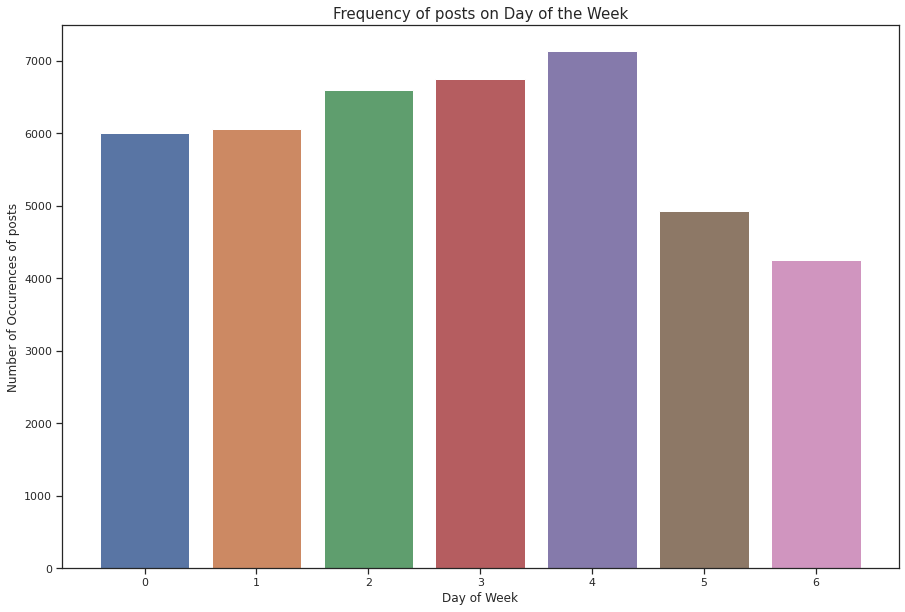

In [13]:
countDow=data['Dow'].value_counts()
plt.figure(figsize=(15,10))
sns.barplot(countDow.index,countDow.values)
plt.ylabel('Number of Occurences of posts',fontsize=12)
plt.xlabel('Day of Week',fontsize=12)
plt.title('Frequency of posts on Day of the Week',fontsize=15)
# plt.xticks(ticks=countDow.index,rotation='vertical')
plt.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


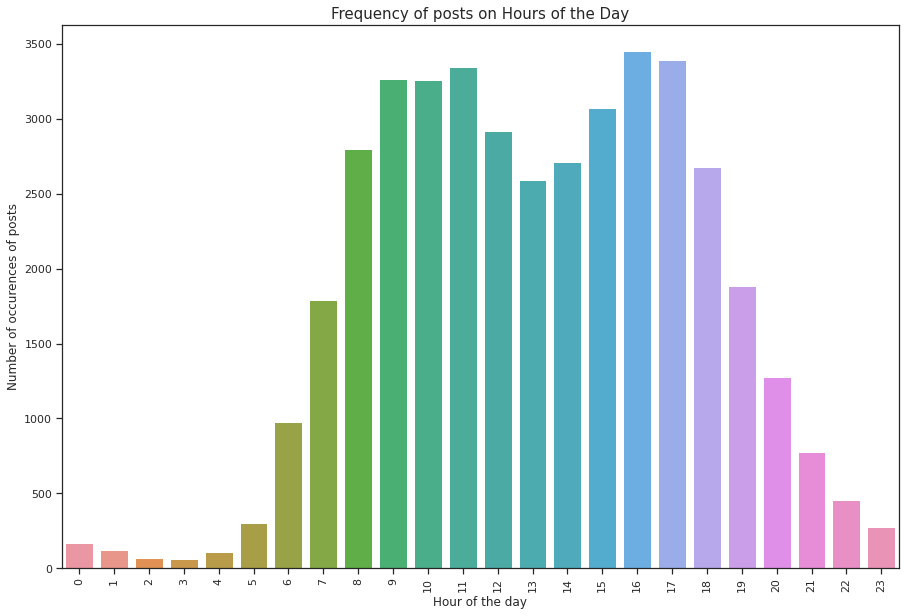

In [14]:
countHour=data['Hod'].value_counts()
plt.figure(figsize=(15,10))
sns.barplot(countHour.index,countHour.values)
plt.ylabel('Number of occurences of posts',fontsize=12)
plt.xlabel('Hour of the day',fontsize=12)
plt.title('Frequency of posts on Hours of the Day',fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

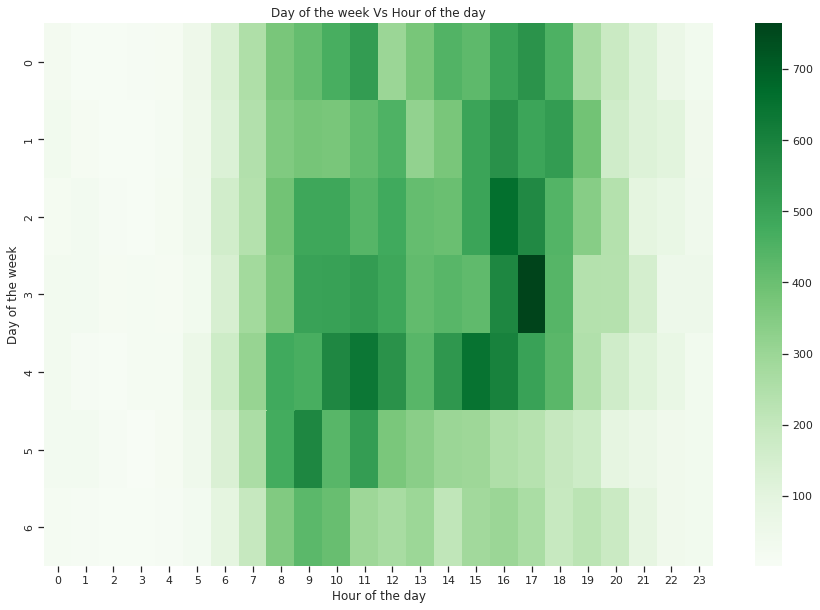

In [15]:
grp = data.groupby(['Dow','Hod'])['followers'].aggregate('count').reset_index()
grp = grp.pivot(index='Dow',columns='Hod',values='followers')
plt.figure(figsize=(15,10))
sns.heatmap(grp,cmap='Greens')
plt.title("Day of the week Vs Hour of the day")
plt.xlabel('Hour of the day')
plt.ylabel('Day of the week')
plt.show()

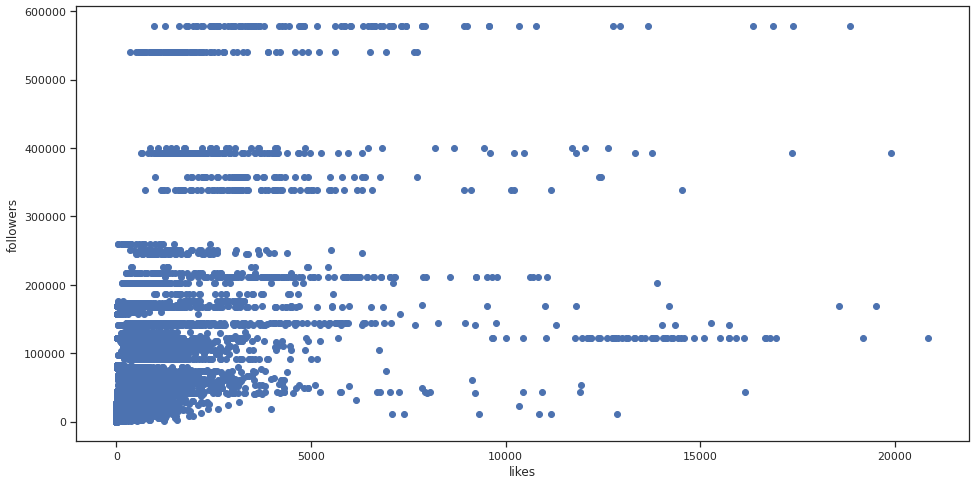

In [16]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['likes'], data['followers'])
ax.set_xlabel('likes')
ax.set_ylabel('followers')
plt.show()

In [17]:
data['mon']=(data['Dow']==0).astype(int)
data['tue']=(data['Dow']==1).astype(int)
data['wed']=(data['Dow']==2).astype(int)
data['thu']=(data['Dow']==3).astype(int)
data['fri']=(data['Dow']==4).astype(int)
data['sat']=(data['Dow']==5).astype(int)
data['sun']=(data['Dow']==6).astype(int)

In [18]:
data = data.drop(['Dow'], axis=1)
data.drop(['datetime'], axis=1, inplace=True)

In [19]:
data

,account,caption,following,likes,posts_count,followers,comments,Hod,Date,mon,tue,wed,thu,fri,sat,sun
10,chelsea_bridge_clinic,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,0.0,10,2021-02-08,1,0,0,0,0,0,0
11,chelsea_bridge_clinic,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,0.0,14,2021-01-21,0,0,0,1,0,0,0
12,numberoneedin,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,2.0,17,2022-02-19,0,0,0,0,0,1,0
13,numberoneedin,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,1.0,20,2022-01-31,1,0,0,0,0,0,0
14,numberoneedin,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,1.0,18,2022-01-26,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74544,thesavoylondon,"Alongside hospitality, the performing arts hav...",599.0,4079.0,1933.0,167394.0,67.0,17,2021-01-15,0,0,0,0,1,0,0
74545,thesavoylondon,This! Isn’t this what we are looking forward ...,599.0,1621.0,1933.0,167394.0,34.0,14,2021-01-13,0,0,1,0,0,0,0
74546,thesavoylondon,"For those of you who are missing London town, ...",599.0,1548.0,1933.0,167394.0,28.0,12,2021-01-11,1,0,0,0,0,0,0
74547,thesavoylondon,While we’re closed we’re going to try and keep...,599.0,2637.0,1933.0,167394.0,68.0,13,2021-01-06,0,0,1,0,0,0,0


In [20]:
a=df['account'].nunique(dropna = True)

In [21]:
data1 = data.iloc[:]

###average_five_recent_likes

In [22]:
data1[data1['account'] == 0]['likes'].aggregate('mean')
a = data1.groupby(by = ['account'])['likes'].aggregate('mean').to_frame('avg_likes')
a.head()

,avg_likes
account,
108harleystreet,4.541667
111skin,276.060606
144onthehill,49.250000
1gemmaclare,59.857143
2magpiesbakery,321.625000


In [23]:
x = pd.merge(data1, a, on = 'account')

In [24]:
pd.DataFrame(data1.groupby(by=['account'])['likes']).iloc[0][1]
recent_likes=data1.groupby(by=['account'])['likes'].apply(lambda x: x.tail(5).mean())
x = pd.merge(x, recent_likes, on = 'account')
x.rename({'likes_y': 'average_five_recent_likes'}, axis=1, inplace=True)

In [25]:
data=x
data.shape

(41741, 18)

###Label Encoding

In [26]:
le = preprocessing.LabelEncoder()
le.fit(data["account"])
list(le.classes_)
account_num=le.transform(data["account"])
data["account"]=account_num

In [27]:
type(data)

pandas.core.frame.DataFrame

In [28]:
data.drop(['comments'], axis=1, inplace=True)
data.drop(['Date'], axis=1, inplace=True)
data=data.astype(str)

In [29]:
data

,account,caption,following,likes_x,posts_count,followers,Hod,mon,tue,wed,thu,fri,sat,sun,avg_likes,average_five_recent_likes
0,98,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,10,1,0,0,0,0,0,0,13.0,13.0
1,98,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,14,0,0,0,1,0,0,0,13.0,13.0
2,416,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,17,0,0,0,0,0,1,0,128.125,158.6
3,416,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,20,1,0,0,0,0,0,0,128.125,158.6
4,416,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,18,0,0,1,0,0,0,0,128.125,158.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,471,Our team of gardeners ensure that every month ...,1290.0,97.0,1118.0,11336.0,11,1,0,0,0,0,0,0,179.29787234042553,121.2
41737,471,Here's to the Bank Holiday weekend! 🍹\n\n📸 @ka...,1290.0,125.0,1118.0,11336.0,16,0,0,0,0,1,0,0,179.29787234042553,121.2
41738,471,Amongst our favourite sights in late spring is...,1290.0,125.0,1118.0,11336.0,7,0,0,0,1,0,0,0,179.29787234042553,121.2
41739,471,Our new awards have just arrived from the Sout...,1290.0,107.0,1118.0,11336.0,11,0,0,1,0,0,0,0,179.29787234042553,121.2


#NLP Features

In [30]:
from textblob import TextBlob


def sentiment_analysis(caption):
 def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity
  
 #Create a function to get the polarity
 def getPolarity(caption):
   return TextBlob(caption).sentiment.polarity
  
 #Create two new columns ‘Subjectivity’ & ‘Polarity’
 data['TextBlob_Subjectivity'] =    data['caption'].apply(getSubjectivity)
 data ['TextBlob_Polarity'] = data['caption'].apply(getPolarity)


 def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'


 data ['TextBlob_Analysis'] = data['TextBlob_Polarity'].apply(getAnalysis )
 return data

In [31]:
sentiment_analysis(data['caption'])

,account,caption,following,likes_x,posts_count,followers,Hod,mon,tue,wed,thu,fri,sat,sun,avg_likes,average_five_recent_likes,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis
0,98,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,10,1,0,0,0,0,0,0,13.0,13.0,0.632390,0.282576,Positive
1,98,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,14,0,0,0,1,0,0,0,13.0,13.0,0.405556,0.168056,Positive
2,416,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,17,0,0,0,0,0,1,0,128.125,158.6,0.000000,0.000000,Neutral
3,416,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,20,1,0,0,0,0,0,0,128.125,158.6,0.333333,0.250000,Positive
4,416,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,18,0,0,1,0,0,0,0,128.125,158.6,0.333333,0.166667,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,471,Our team of gardeners ensure that every month ...,1290.0,97.0,1118.0,11336.0,11,1,0,0,0,0,0,0,179.29787234042553,121.2,0.560909,0.322273,Positive
41737,471,Here's to the Bank Holiday weekend! 🍹\n\n📸 @ka...,1290.0,125.0,1118.0,11336.0,16,0,0,0,0,1,0,0,179.29787234042553,121.2,0.000000,0.000000,Neutral
41738,471,Amongst our favourite sights in late spring is...,1290.0,125.0,1118.0,11336.0,7,0,0,0,1,0,0,0,179.29787234042553,121.2,0.516667,-0.280208,Negative
41739,471,Our new awards have just arrived from the Sout...,1290.0,107.0,1118.0,11336.0,11,0,0,1,0,0,0,0,179.29787234042553,121.2,0.643615,0.396834,Positive


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


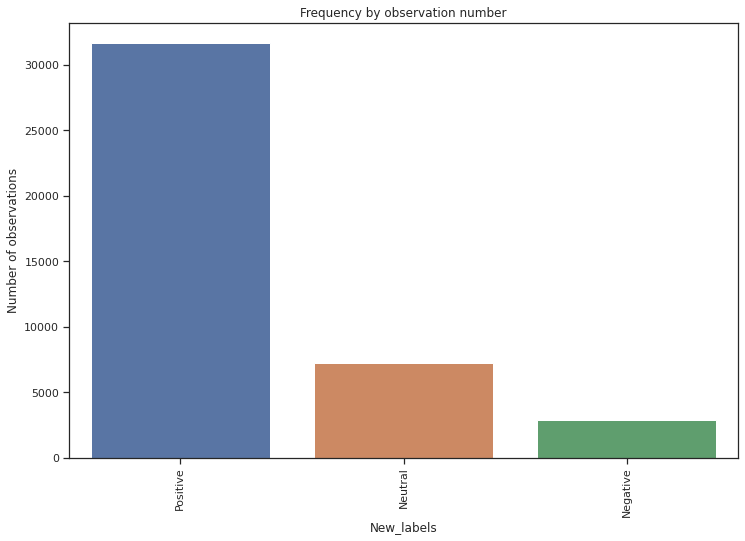

In [32]:
countSet = data['TextBlob_Analysis'].value_counts()
countSet

plt.figure(figsize=(12,8))
sns.barplot(countSet.index,countSet.values,)
plt.ylabel('Number of observations')
plt.xlabel('New_labels')
plt.title('Frequency by observation number')
plt.xticks(rotation='vertical')
plt.show()

In [33]:
data.dtypes

account                       object
caption                       object
following                     object
likes_x                       object
posts_count                   object
followers                     object
Hod                           object
mon                           object
tue                           object
wed                           object
thu                           object
fri                           object
sat                           object
sun                           object
avg_likes                     object
average_five_recent_likes     object
TextBlob_Subjectivity        float64
TextBlob_Polarity            float64
TextBlob_Analysis             object
dtype: object

In [34]:
dropped = ['TextBlob_Polarity','TextBlob_Subjectivity']
data = data.drop(dropped,axis=1)
data = data.iloc[: , 1:]

In [35]:
hashtag_summary = adv.extract_hashtags(data['caption'])
hashtag_summary.keys()

dict_keys(['hashtags', 'hashtags_flat', 'hashtag_counts', 'hashtag_freq', 'top_hashtags', 'overview'])

In [36]:
hashtag_summary['hashtag_freq'][:10]

[(0, 14969),
 (1, 2732),
 (2, 1567),
 (3, 2018),
 (4, 1524),
 (5, 1581),
 (6, 1420),
 (7, 1332),
 (8, 1335),
 (9, 1134)]

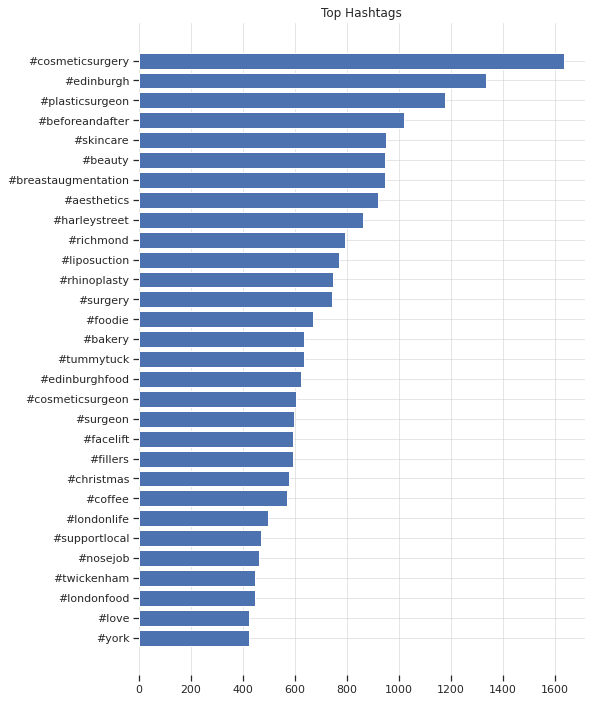

In [37]:
plt.figure(facecolor='white', figsize=(8, 12))
plt.barh([x[0] for x in hashtag_summary['top_hashtags'][2:][:30]][::-1],
         [x[1] for x in hashtag_summary['top_hashtags'][2:][:30]][::-1])
plt.title('Top Hashtags')
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)

###emoji

In [38]:
emoji_summary = adv.extract_emoji(data['caption'])
emoji_summary.keys()

dict_keys(['emoji', 'emoji_text', 'emoji_flat', 'emoji_flat_text', 'emoji_counts', 'emoji_freq', 'top_emoji', 'top_emoji_text', 'top_emoji_groups', 'top_emoji_sub_groups', 'overview'])

In [39]:
top_emoji_text=emoji_summary['top_emoji_text']
top_emoji_text

[('sparkles', 3657),
 ('camera with flash', 2149),
 ('red heart', 2074),
 ('smiling face with heart-eyes', 1753),
 ('Christmas tree', 1189),
 ('star', 1176),
 ('white heart', 1161),
 ('telephone receiver', 1029),
 ('telephone', 1020),
 ('black small square', 992),
 ('round pushpin', 952),
 ('party popper', 862),
 ('blue heart', 860),
 ('clinking glasses', 859),
 ('star-struck', 838),
 ('cherry blossom', 814),
 ('raising hands', 794),
 ('hot beverage', 793),
 ('sun', 776),
 ('e-mail', 776),
 ('check mark button', 761),
 ('face savoring food', 707),
 ('syringe', 703),
 ('check mark', 688),
 ('two hearts', 685),
 ('fire', 683),
 ('camera', 659),
 ('eyes', 648),
 ('backhand index pointing right', 634),
 ('pizza', 611),
 ('dizzy', 607),
 ('glowing star', 594),
 ('drooling face', 563),
 ('right arrow', 548),
 ('folded hands', 534),
 ('cocktail glass', 525),
 ('smiling face with hearts', 516),
 ('winking face', 508),
 ('collision', 503),
 ('partying face', 495),
 ('yellow heart', 464),
 ('smi

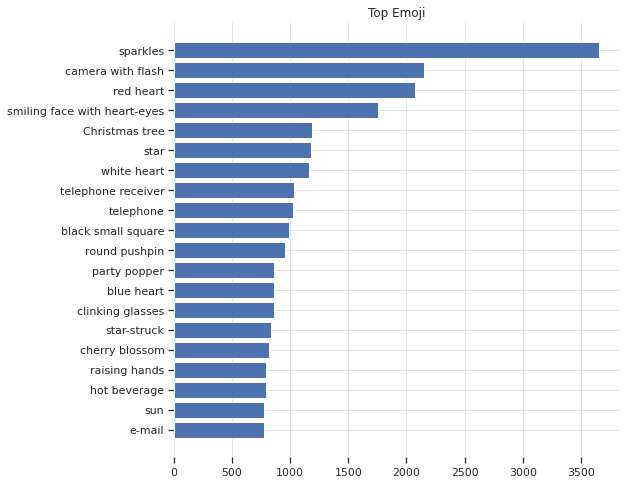

In [40]:
plt.figure(facecolor='white', figsize=(8, 8))
plt.barh([x[0] for x in emoji_summary['top_emoji_text'][:20]][::-1],
         [x[1] for x in emoji_summary['top_emoji_text'][:20]][::-1])
plt.title('Top Emoji')
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)

###mention

In [41]:
mention_summary = adv.extract_mentions(data['caption'])
mention_summary.keys()

dict_keys(['mentions', 'mentions_flat', 'mention_counts', 'mention_freq', 'top_mentions', 'overview'])

In [42]:
mentions=mention_summary['top_mentions']
type(mentions)

list

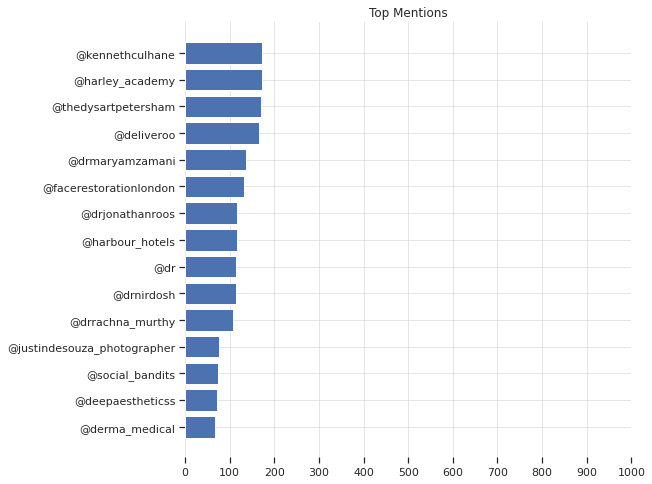

In [43]:
plt.figure(facecolor='white', figsize=(8, 8))
plt.barh([x[0] for x in mention_summary['top_mentions'][:15]][::-1],
         [x[1] for x in mention_summary['top_mentions'][:15]][::-1])
plt.title('Top Mentions')
plt.grid(alpha=0.5)
plt.xticks(range(0, 1100, 100))
plt.gca().set_frame_on(False)

###Frame dataset

In [44]:
extracted_tweets =  (data.assign(hashtags=hashtag_summary['hashtags'],
         hashcounts=hashtag_summary['hashtag_counts'],
         mentions=mention_summary['mentions'],
         mention_count=mention_summary['mention_counts'],
         emoji=emoji_summary['emoji'],
          emoji_text=emoji_summary['emoji_text'],
         emoji_count=emoji_summary['emoji_counts']         
         ))

extracted_tweets.head(5)

,caption,following,likes_x,posts_count,followers,Hod,mon,tue,wed,thu,...,avg_likes,average_five_recent_likes,TextBlob_Analysis,hashtags,hashcounts,mentions,mention_count,emoji,emoji_text,emoji_count
0,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,10,1,0,0,0,...,13.0,13.0,Positive,"[#londontesting, #chelseabridgeclinic, #london...",8,[],0,"[⏱, 📄, 🧑🏻‍⚕️, 👨‍👩‍👧‍👦, 👫, 🧑‍💻, 🤍, 📌, 🦠, 🤝]","[stopwatch, page facing up, health worker: lig...",10
1,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,14,0,0,0,1,...,13.0,13.0,Positive,"[#thankyou, #thankful, #feedback, #chlseabridg...",9,[],0,"[👏, 🧡]","[clapping hands, orange heart]",2
2,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,17,0,0,0,0,...,128.125,158.6,Neutral,"[#edinburghfoodies, #edinburghrestaurants, #nu...",25,[],0,[],[],0
3,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,20,1,0,0,0,...,128.125,158.6,Positive,"[#michelin, #michelinstar, #michelinuk, #edinb...",28,[],0,[],[],0
4,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,18,0,0,1,0,...,128.125,158.6,Positive,"[#michelin, #michelinstar, #michelinuk, #edinb...",28,"[@castlegamescotland, @wellocksfood]",2,[],[],0


In [45]:
le = preprocessing.LabelEncoder()
le.fit(extracted_tweets["TextBlob_Analysis"])
list(le.classes_)
account_num=le.transform(extracted_tweets["TextBlob_Analysis"])
extracted_tweets["TextBlob_Analysis"]=account_num

In [46]:
#Converting the columns into the float datatype
a=['followers']
for i in a:
  extracted_tweets[i]= extracted_tweets[i].astype(str).astype(float)
extracted_tweets

,caption,following,likes_x,posts_count,followers,Hod,mon,tue,wed,thu,...,avg_likes,average_five_recent_likes,TextBlob_Analysis,hashtags,hashcounts,mentions,mention_count,emoji,emoji_text,emoji_count
0,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,10,1,0,0,0,...,13.0,13.0,2,"[#londontesting, #chelseabridgeclinic, #london...",8,[],0,"[⏱, 📄, 🧑🏻‍⚕️, 👨‍👩‍👧‍👦, 👫, 🧑‍💻, 🤍, 📌, 🦠, 🤝]","[stopwatch, page facing up, health worker: lig...",10
1,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,14,0,0,0,1,...,13.0,13.0,2,"[#thankyou, #thankful, #feedback, #chlseabridg...",9,[],0,"[👏, 🧡]","[clapping hands, orange heart]",2
2,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,17,0,0,0,0,...,128.125,158.6,1,"[#edinburghfoodies, #edinburghrestaurants, #nu...",25,[],0,[],[],0
3,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,20,1,0,0,0,...,128.125,158.6,2,"[#michelin, #michelinstar, #michelinuk, #edinb...",28,[],0,[],[],0
4,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,18,0,0,1,0,...,128.125,158.6,2,"[#michelin, #michelinstar, #michelinuk, #edinb...",28,"[@castlegamescotland, @wellocksfood]",2,[],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,Our team of gardeners ensure that every month ...,1290.0,97.0,1118.0,11336.0,11,1,0,0,0,...,179.29787234042553,121.2,2,"[#allium, #alliumgiganteum, #alliums, #gardeni...",28,[],0,"[🌿, 🐝]","[herb, honeybee]",2
41737,Here's to the Bank Holiday weekend! 🍹\n\n📸 @ka...,1290.0,125.0,1118.0,11336.0,16,0,0,0,0,...,179.29787234042553,121.2,1,"[#cocktailsinthegarden, #drinksinthegarden, #c...",15,[@kateauthers],1,"[🍹, 📸]","[tropical drink, camera with flash]",2
41738,Amongst our favourite sights in late spring is...,1290.0,125.0,1118.0,11336.0,7,0,0,0,1,...,179.29787234042553,121.2,0,"[#clematis, #springflowers, #blackcherryplum, ...",18,[],0,[🌸],[cherry blossom],1
41739,Our new awards have just arrived from the Sout...,1290.0,107.0,1118.0,11336.0,11,0,0,1,0,...,179.29787234042553,121.2,2,"[#awardwinninghotel, #besthotel, #luxuryhotel,...",17,[],0,"[☀️, 🌡, 🌳]","[sun, thermometer, deciduous tree]",3


In [47]:
extracted_tweets.dtypes

caption                       object
following                     object
likes_x                       object
posts_count                   object
followers                    float64
Hod                           object
mon                           object
tue                           object
wed                           object
thu                           object
fri                           object
sat                           object
sun                           object
avg_likes                     object
average_five_recent_likes     object
TextBlob_Analysis              int64
hashtags                      object
hashcounts                     int64
mentions                      object
mention_count                  int64
emoji                         object
emoji_text                    object
emoji_count                    int64
dtype: object

Let's say 10 people, each with 100 followers posted using the hashtag #basketball in their instagram.

Therefore those post are expected to potentially reach 10 x 100 = 1,000 people (not really that much because of follower overlap, and not everyone sees all post, but we will use this simplified assumption for now).
Let's also assume that only one person used the hashtag #NFL in these post. And let's also assume that this person has 20,000 followers. Then which hashtag reached more users?
Obviously #NFL would reach more because, although only one person posted it, that one person had more followers than the ten others who posted #basketball combined.



https://www.datacamp.com/community/tutorials/absolute-weighted-word-frequency

In [48]:
word_freq_hash = adv.word_frequency(extracted_tweets['hashtags'].str.join(' '), extracted_tweets['followers'].fillna(0))
word_freq_hash.head()
# type(word_freq_hash.word)

,word,abs_freq,wtd_freq,rel_value
0,#london,2955,53251817.0,18021.0
1,#peggyporschen,82,47393950.0,577975.0
2,#plasticsurgery,2074,44513337.0,21463.0
3,#nhs,136,36689678.0,269777.0
4,#cosmeticsurgery,1635,34204590.0,20920.0


In [49]:
d=pd.Series(word_freq_hash.rel_value.values,index=word_freq_hash.word.values ).to_dict()
print(d.get('#chelseabridgeclinic'))
print(d.get('#london'))
print(d.get('#test'))

1093.0
18021.0
1093.0


In [50]:
def countHashtags(tags):
  if len(tags)==0:
    return 0
  sum = 0
  for i in tags:
    sum += (d.get(i))
  return sum/len(tags)

In [51]:
extracted_tweets['hashtags'][10]

['#naturalwines',
 '#organicvines',
 '#emilien',
 '#biodynamicwines',
 '#michelin',
 '#michelinstar',
 '#michelinuk',
 '#edinburghfoodies',
 '#edinburghrestaurants',
 '#numberone',
 '#thebalmoral',
 '#roccofortehotels',
 '#roccofortefriends',
 '#edinburgh',
 '#igersedinburgh',
 '#scotland',
 '#visitedinburgh',
 '#foreveredinburgh',
 '#visitscotland',
 '#scotlandisnow',
 '#travel',
 '#traveller',
 '#balmoralmoments',
 '#edinburghsnapshots',
 '#edinburghcity',
 '#edinburghlife',
 '#hotellife',
 '#photography',
 '#photooftheday']

In [52]:
hashtag_average = extracted_tweets['hashtags'].apply(countHashtags)
extracted_tweets['hashtag_popularity'] = hashtag_average

In [53]:
extracted_tweets

,caption,following,likes_x,posts_count,followers,Hod,mon,tue,wed,thu,...,average_five_recent_likes,TextBlob_Analysis,hashtags,hashcounts,mentions,mention_count,emoji,emoji_text,emoji_count,hashtag_popularity
0,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,10,1,0,0,0,...,13.0,2,"[#londontesting, #chelseabridgeclinic, #london...",8,[],0,"[⏱, 📄, 🧑🏻‍⚕️, 👨‍👩‍👧‍👦, 👫, 🧑‍💻, 🤍, 📌, 🦠, 🤝]","[stopwatch, page facing up, health worker: lig...",10,3219.750000
1,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,14,0,0,0,1,...,13.0,2,"[#thankyou, #thankful, #feedback, #chlseabridg...",9,[],0,"[👏, 🧡]","[clapping hands, orange heart]",2,5178.333333
2,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,17,0,0,0,0,...,158.6,1,"[#edinburghfoodies, #edinburghrestaurants, #nu...",25,[],0,[],[],0,17663.680000
3,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,20,1,0,0,0,...,158.6,2,"[#michelin, #michelinstar, #michelinuk, #edinb...",28,[],0,[],[],0,16841.857143
4,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,18,0,0,1,0,...,158.6,2,"[#michelin, #michelinstar, #michelinuk, #edinb...",28,"[@castlegamescotland, @wellocksfood]",2,[],[],0,16841.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,Our team of gardeners ensure that every month ...,1290.0,97.0,1118.0,11336.0,11,1,0,0,0,...,121.2,2,"[#allium, #alliumgiganteum, #alliums, #gardeni...",28,[],0,"[🌿, 🐝]","[herb, honeybee]",2,14067.857143
41737,Here's to the Bank Holiday weekend! 🍹\n\n📸 @ka...,1290.0,125.0,1118.0,11336.0,16,0,0,0,0,...,121.2,1,"[#cocktailsinthegarden, #drinksinthegarden, #c...",15,[@kateauthers],1,"[🍹, 📸]","[tropical drink, camera with flash]",2,16134.733333
41738,Amongst our favourite sights in late spring is...,1290.0,125.0,1118.0,11336.0,7,0,0,0,1,...,121.2,0,"[#clematis, #springflowers, #blackcherryplum, ...",18,[],0,[🌸],[cherry blossom],1,12696.388889
41739,Our new awards have just arrived from the Sout...,1290.0,107.0,1118.0,11336.0,11,0,0,1,0,...,121.2,2,"[#awardwinninghotel, #besthotel, #luxuryhotel,...",17,[],0,"[☀️, 🌡, 🌳]","[sun, thermometer, deciduous tree]",3,17488.117647


#Preprocessing

In [57]:
PREPROCESSING_PIPELINE = [translation,
                          clean_mention,
                          clean_hashtags,
                          lower,
                          replace_special_characters,
                          replace_br,
                          filter_out_uncommon_symbols,
                          replace_by_underscore,
                          remove_stopwords,
                          strip_text,
                          remove_emoji]

PREPROCESSING_PIPELINE1 = [remove_brackets_from_list]


# Anchor method

def text_prepare(text: str,filter_methods = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)



def text_prepare1(text: str,filter_methods = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE1

    return reduce(lambda txt, f: f(txt), filter_methods, text)


L=['hashtags','emoji_text','mentions']
A=['caption','emoji_text']

for i in L:
  extracted_tweets[i] = extracted_tweets[i].apply(lambda txt: text_prepare1(str(txt)[1:-1]))

for i in A:
  extracted_tweets[i]=extracted_tweets[i].apply(lambda txt: text_prepare(str(txt)))


extracted_tweets

,caption,following,likes_x,posts_count,followers,Hod,mon,tue,wed,thu,...,average_five_recent_likes,TextBlob_Analysis,hashtags,hashcounts,mentions,mention_count,emoji,emoji_text,emoji_count,hashtag_popularity
0,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,10,1,0,0,0,...,13.0,2,"londontesting', '#chelseabridgeclinic', '#lond...",8,,0,"[⏱, 📄, 🧑🏻‍⚕️, 👨‍👩‍👧‍👦, 👫, 🧑‍💻, 🤍, 📌, 🦠, 🤝]",topwatch' 'page facing up' 'health worker: lig...,10,3219.750000
1,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 We grateful kind words feedback rec...,964.0,12.0,47.0,1093.0,14,0,0,0,1,...,13.0,2,"thankyou', '#thankful', '#feedback', '#chlseab...",9,,0,"[👏, 🧡]",lapping hands' 'orange hear,2,5178.333333
2,Hand dived Isle Jura scallop smoked roe leek c...,308.0,100.0,343.0,4202.0,17,0,0,0,0,...,158.6,1,"edinburghfoodies', '#edinburghrestaurants', '#...",25,,0,[],,0,17663.680000
3,Jerusalem Artichoke prepared first dessert mal...,308.0,81.0,343.0,4202.0,20,1,0,0,0,...,158.6,2,"michelin', '#michelinstar', '#michelinuk', '#e...",28,,0,[],,0,16841.857143
4,Main course seasonal course menu: Borders Roe...,308.0,146.0,343.0,4202.0,18,0,0,1,0,...,158.6,2,"michelin', '#michelinstar', '#michelinuk', '#e...",28,"castlegamescotland', '@wellocksfoo",2,[],,0,16841.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,Our team gardeners ensure every month somethin...,1290.0,97.0,1118.0,11336.0,11,1,0,0,0,...,121.2,2,"allium', '#alliumgiganteum', '#alliums', '#gar...",28,,0,"[🌿, 🐝]",erb' 'honeybe,2,14067.857143
41737,Here's Bank Holiday weekend,1290.0,125.0,1118.0,11336.0,16,0,0,0,0,...,121.2,1,"cocktailsinthegarden', '#drinksinthegarden', '...",15,kateauther,1,"[🍹, 📸]",tropical drink' 'camera flas,2,16134.733333
41738,Amongst favourite sights late spring clematis ...,1290.0,125.0,1118.0,11336.0,7,0,0,0,1,...,121.2,0,"clematis', '#springflowers', '#blackcherryplum...",18,,0,[🌸],Cherry Blossom,1,12696.388889
41739,Our new awards arrived South West Tourism Awar...,1290.0,107.0,1118.0,11336.0,11,0,0,1,0,...,121.2,2,"awardwinninghotel', '#besthotel', '#luxuryhote...",17,,0,"[☀️, 🌡, 🌳]",un' 'thermometer' 'deciduous tre,3,17488.117647


In [58]:
emoji_summary = adv.extract_emoji(extracted_tweets['caption'])
emoji_summary.keys()

emoji_summary['top_emoji'][:10]

[]

In [61]:
mention_summary = adv.extract_mentions(extracted_tweets['caption'])
mention_summary.keys()

mention_summary['top_mentions'][:10]

[('＠soi', 1)]

In [63]:
hashtag_summary = adv.extract_hashtags(extracted_tweets['caption'])
hashtag_summary.keys()

hashtag_summary['top_hashtags'][:10]

[]

In [64]:
extracted_tweets.to_csv('/content/drive/MyDrive/NLP/FinaDataset.csv')

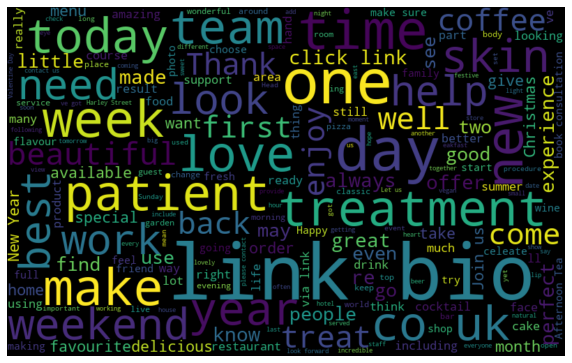

In [65]:
#Understanding the common words used in the captions: WordCloud

all_words = ' '.join([text for text in extracted_tweets['caption']]) 
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

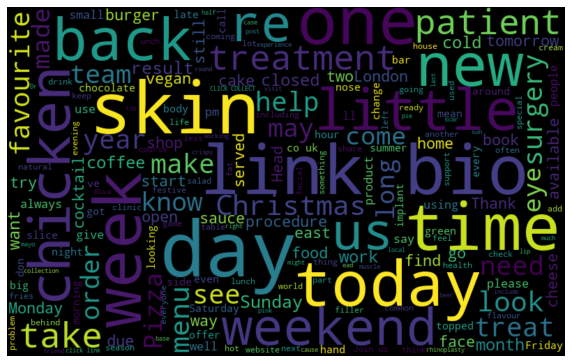

In [68]:
#Understanding the common words used in the Positive captions: WordCloud

normal_words =' '.join([text for text in extracted_tweets['caption'][extracted_tweets['TextBlob_Analysis'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

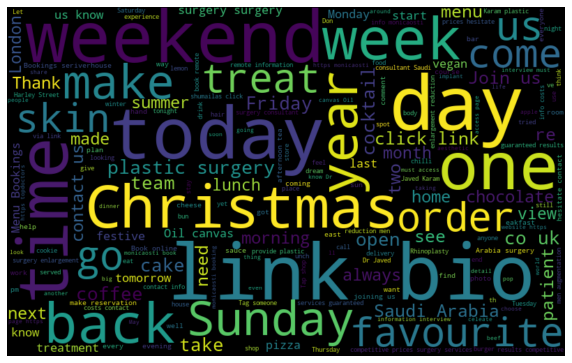

In [70]:
#Understanding the common words used in the Neutral captions: WordCloud

normal_words =' '.join([text for text in extracted_tweets['caption'][extracted_tweets['TextBlob_Analysis'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

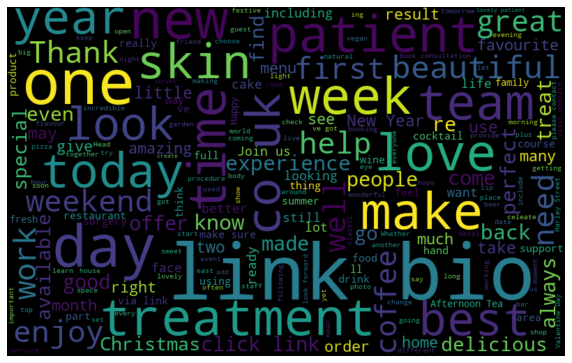

In [72]:
#Understanding the common words used in the Negative captions: WordCloud

normal_words =' '.join([text for text in extracted_tweets['caption'][extracted_tweets['TextBlob_Analysis'] == 2]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

##BOW

In [73]:
def Feature_Extraction(dataframe,n,featureExtraction):
  vectorizer = featureExtraction(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 250)
  bow_words = vectorizer.fit_transform(dataframe)
  bow_clean = bow_words.toarray()
  vocab = vectorizer.get_feature_names()
  # print(vocab)
  new_vocab = []
  for word in vocab:
    if len(word)>n:
      new_vocab.append(word)
  print (' '.join(new_vocab))
  words_clean = pd.DataFrame(data=bow_clean, columns=vocab)
  # words_clean.head()
  j1 = words_clean.columns.get_level_values(0).isin(new_vocab)
  words_clean = words_clean.loc[:,j1]
  # words_clean.head()
  return words_clean

In [74]:
bow_caption=Feature_Extraction(extracted_tweets['caption'],0,CountVectorizer)
bow_caption

afternoon all also always am amazing and another area around as available away back bar beautiful best better big bio body book cake call can care celeate check cheese chocolate christmas click clinic co coffee com come coming consultation contact cosmetic could course cream day days delicious delivery dm don done dr east email enjoy even every everyone experience face facial family fat favourite feel festive find first follow food for forward free fresh friday friends from full get gift give go going good got great hair happy have head health help here home hope hot house https if in including info information it join keep know last learn let life lift like link little ll local london long look looking love lovely lunch made make many may menu monday month months morning mr much natural need new next night no non offer on one online open order our part patient patients people perfect place please pm post procedure re ready really result results right room saturday say see share shop s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,afternoon,all,also,always,am,amazing,and,another,area,around,...,without,wonderful,work,working,world,would,www,year,years,you
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
41737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
41739,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,2,0,0


In [76]:
bow_hashtags=Feature_Extraction(extracted_tweets['hashtags'],0,CountVectorizer)
bow_hashtags

abdominoplasty aesthetic aestheticmedicine aesthetics aestheticsurgery afternoontea alabashir antiageing antiaging art artisan artist artistsoninstagram artwork bakery baking beauty beforeandafter bestfornoses blepharoplasty bodycontouring boobjob botox boutiquehotel bread breakfast breast breastaugmentation breastenhancement breastenlargement breastimplants breastlift breastreduction breastsurgeon breastsurgery breastuplift britishart britishartist brunch brunchgoals burgers cafe cake cakestagram chef chefsofinstagram chelsea chocolate christmas cocktails coffee coffeegram coffeeshop coffeetime confidence cosmetic cosmeticdoctor cosmetics cosmeticsurgeon cosmeticsurgery cosmeticsurgerylondon croissant delicious deliveroo dentist dermalfiller dermalfillers dessert dinner doctor doctors doctorsofinstagram eastandbadia edinburgh edinburghfood edinburghfoodie edinburghlife edinburghrestaurant eyelidsurgery facelift facial facialaesthetics facialplasticsurgery fermentation filler fillers f

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abdominoplasty,aesthetic,aestheticmedicine,aesthetics,aestheticsurgery,afternoontea,alabashir,antiageing,antiaging,art,...,طبيب,طبيب_عراقي,عراق,عراقي,علاء_بشير,فن,فن_عربي,فنان_عراقي,فنون,فنون_عربيه
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
bow_emoji_text=Feature_Extraction(extracted_tweets['emoji_text'],0,CountVectorizer)
bow_emoji_text

ace africa alarm americas amulet arro arrow arty artying australia backhand bagel ball balloon banknote bar beaming bed beer beverag beverage biceps big black blossom blowing blue book bottle box bullseye button calendar camera car check cheese cherry chocolate christmas circle clapping claus clinking clock cloud cocktail collision cook cooking cork cream croissant cupcake dancing dark diamond dizzy done doughnut down downwards drink drooling ed elephone email envelope europe exclamation eye eyes fac face fire flag flas flash flexed floor fluttering folded foo food fork gif gift glas glass glasse glasses globe glowing green grinning hair hamburger han hand hands head health hear heart hearts high hite hospital hot hourglass hugging ice index ine inking ire izzy jack joy keycap kingdom kiss knife lag lantern lapping laptop laughing lea leaf left light linking love lowing lue magnifying mai mail man mar mark mask medical medium meridians miling mobile moon mouth mug mugs musical nazar no

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ace,africa,alarm,americas,amulet,arro,arrow,arty,artying,australia,...,wedge,white,wind,wine,winking,woman,worker,wrapped,yellow,yes
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,2,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
bow_mentions=Feature_Extraction(extracted_tweets['mentions'],0,CountVectorizer)
bow_mentions

108marylebonelan 108marylebonelane 2tall 40ftbrewery aberdeensurgeo aestheticscourse aestheticsjournalu aestheticsjournaluk aestheticsourceofficial aibeautyclini alessandro_palazz allergansparkuk ameeralondonstor ameliaclaudi aperolspritzu asa barchrichmon barchrichmond be beyouwithbianca binghamriverhous binghamriverhouse blackswan_oldstea blackswan_oldstead breastimplantsbymento bristol_beaco bross_bagel bsshan cacklebean_eggs catrionadonaldson cazcabeltequil ccrlondon channel chelseyredwood ciaralawless1 companybaker coolstays cosmeticsurgeonslondo coventgardenld crescipizzeri curiocollectio curiousroocoffeeroasters deepaesthetics deepaestheticss delivero deliveroo dem dentalartimplantclinic derma_medica dermadents dirtywitches doctif dontfretseejennett dr dr_emily_m draayoub drdominicbra drgaryfhor drivogwanmesi drjonathanroo drjonathanroos drkalpnapindolia drmariamirand drmaryamzaman drmaryamzamani drmattegan91 drnirdos drnirdosh drpau drrachna_murthy drsomji_ski drtedmil drtedmil

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,108marylebonelan,108marylebonelane,2tall,40ftbrewery,aberdeensurgeo,aestheticscourse,aestheticsjournalu,aestheticsjournaluk,aestheticsourceofficial,aibeautyclini,...,ukenhancemedical,visitmalto,waitrose,walkwithamir,wearecornerstor,welchfishmonger,wildfarme,withregram,youngspub,zoskinhealth_u
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
bow_dataset = pd.DataFrame(np.hstack((bow_caption,bow_hashtags,bow_emoji_text,bow_mentions,extracted_tweets)))

In [80]:
bow_dataset

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,1,...,13.0,2,"londontesting', '#chelseabridgeclinic', '#lond...",8,,0,"[⏱, 📄, 🧑🏻‍⚕️, 👨‍👩‍👧‍👦, 👫, 🧑‍💻, 🤍, 📌, 🦠, 🤝]",topwatch' 'page facing up' 'health worker: lig...,10,3219.75
1,0,0,0,0,0,0,0,0,0,0,...,13.0,2,"thankyou', '#thankful', '#feedback', '#chlseab...",9,,0,"[👏, 🧡]",lapping hands' 'orange hear,2,5178.333333
2,0,0,0,0,0,0,0,0,0,0,...,158.6,1,"edinburghfoodies', '#edinburghrestaurants', '#...",25,,0,[],,0,17663.68
3,0,0,0,0,0,0,0,0,0,0,...,158.6,2,"michelin', '#michelinstar', '#michelinuk', '#e...",28,,0,[],,0,16841.857143
4,0,0,0,0,0,0,0,0,0,0,...,158.6,2,"michelin', '#michelinstar', '#michelinuk', '#e...",28,"castlegamescotland', '@wellocksfoo",2,[],,0,16841.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0,0,0,0,0,0,0,0,0,0,...,121.2,2,"allium', '#alliumgiganteum', '#alliums', '#gar...",28,,0,"[🌿, 🐝]",erb' 'honeybe,2,14067.857143
41737,0,0,0,0,0,0,0,0,0,0,...,121.2,1,"cocktailsinthegarden', '#drinksinthegarden', '...",15,kateauther,1,"[🍹, 📸]",tropical drink' 'camera flas,2,16134.733333
41738,0,0,0,0,0,0,0,0,0,0,...,121.2,0,"clematis', '#springflowers', '#blackcherryplum...",18,,0,[🌸],Cherry Blossom,1,12696.388889
41739,0,0,0,0,0,0,0,0,0,1,...,121.2,2,"awardwinninghotel', '#besthotel', '#luxuryhote...",17,,0,"[☀️, 🌡, 🌳]",un' 'thermometer' 'deciduous tre,3,17488.117647


In [81]:
dropped = [1000,1016,1018,1020,1021]
bow_dataset = bow_dataset.drop(dropped,axis=1)
bow_dataset

,0,1,2,3,4,5,6,7,8,9,...,1010,1011,1012,1013,1014,1015,1017,1019,1022,1023
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,13.0,13.0,2,8,0,10,3219.75
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,13.0,13.0,2,9,0,2,5178.333333
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,128.125,158.6,1,25,0,0,17663.68
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,128.125,158.6,2,28,0,0,16841.857143
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,128.125,158.6,2,28,2,0,16841.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,179.29787234042553,121.2,2,28,0,2,14067.857143
41737,0,0,0,0,0,0,0,0,0,0,...,1,0,0,179.29787234042553,121.2,1,15,1,2,16134.733333
41738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,179.29787234042553,121.2,0,18,0,1,12696.388889
41739,0,0,0,0,0,0,0,0,0,1,...,0,0,0,179.29787234042553,121.2,2,17,0,3,17488.117647


In [82]:
bow_df = pd.DataFrame(bow_dataset)
bow_data=bow_df.astype(str)

normalizer = preprocessing.MinMaxScaler(feature_range=(0, 1))
bow_normalized_df = pd.DataFrame(normalizer.fit_transform(bow_data),  columns = bow_data.columns)

In [83]:
bow_normalized_df.to_csv('/content/drive/MyDrive/NLP/bow_dataset.csv')

##TF-IDF

In [84]:
tf_idf_caption=Feature_Extraction(extracted_tweets['caption'],5,TfidfVectorizer)
tf_idf_caption

afternoon always amazing another around available beautiful better celeate cheese chocolate christmas clinic coffee coming consultation contact cosmetic course delicious delivery everyone experience facial family favourite festive follow forward friday friends health including information little london looking lovely monday months morning natural online patient patients people perfect please procedure really result results saturday someone something special street summer sunday support surgeon surgery surgical thanks things tomorrow treatment treatments website weekend welcome without wonderful working


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,afternoon,always,amazing,another,around,available,beautiful,better,celeate,cheese,...,things,tomorrow,treatment,treatments,website,weekend,welcome,without,wonderful,working
0,0.0,0.0,0.0,0.0,0.147504,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.268991
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0.0,0.0,0.0,0.0,0.000000,0.0,0.251585,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
41737,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.651827,0.0,0.0,0.0,0.000000
41738,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
41739,0.0,0.0,0.0,0.0,0.309290,0.0,0.279694,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [85]:
tf_idf_hashtags=Feature_Extraction(extracted_tweets['hashtags'],0,TfidfVectorizer)
tf_idf_hashtags

abdominoplasty aesthetic aestheticmedicine aesthetics aestheticsurgery afternoontea alabashir antiageing antiaging art artisan artist artistsoninstagram artwork bakery baking beauty beforeandafter bestfornoses blepharoplasty bodycontouring boobjob botox boutiquehotel bread breakfast breast breastaugmentation breastenhancement breastenlargement breastimplants breastlift breastreduction breastsurgeon breastsurgery breastuplift britishart britishartist brunch brunchgoals burgers cafe cake cakestagram chef chefsofinstagram chelsea chocolate christmas cocktails coffee coffeegram coffeeshop coffeetime confidence cosmetic cosmeticdoctor cosmetics cosmeticsurgeon cosmeticsurgery cosmeticsurgerylondon croissant delicious deliveroo dentist dermalfiller dermalfillers dessert dinner doctor doctors doctorsofinstagram eastandbadia edinburgh edinburghfood edinburghfoodie edinburghlife edinburghrestaurant eyelidsurgery facelift facial facialaesthetics facialplasticsurgery fermentation filler fillers f

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abdominoplasty,aesthetic,aestheticmedicine,aesthetics,aestheticsurgery,afternoontea,alabashir,antiageing,antiaging,art,...,طبيب,طبيب_عراقي,عراق,عراقي,علاء_بشير,فن,فن_عربي,فنان_عراقي,فنون,فنون_عربيه
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
tf_idf_emoji_text=Feature_Extraction(extracted_tweets['emoji_text'],0,TfidfVectorizer)
tf_idf_emoji_text

ace africa alarm americas amulet arro arrow arty artying australia backhand bagel ball balloon banknote bar beaming bed beer beverag beverage biceps big black blossom blowing blue book bottle box bullseye button calendar camera car check cheese cherry chocolate christmas circle clapping claus clinking clock cloud cocktail collision cook cooking cork cream croissant cupcake dancing dark diamond dizzy done doughnut down downwards drink drooling ed elephone email envelope europe exclamation eye eyes fac face fire flag flas flash flexed floor fluttering folded foo food fork gif gift glas glass glasse glasses globe glowing green grinning hair hamburger han hand hands head health hear heart hearts high hite hospital hot hourglass hugging ice index ine inking ire izzy jack joy keycap kingdom kiss knife lag lantern lapping laptop laughing lea leaf left light linking love lowing lue magnifying mai mail man mar mark mask medical medium meridians miling mobile moon mouth mug mugs musical nazar no

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ace,africa,alarm,americas,amulet,arro,arrow,arty,artying,australia,...,wedge,white,wind,wine,winking,woman,worker,wrapped,yellow,yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.276479,0.0,0.000000,0.0,0.495565,0.258354,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
41737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
41738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
41739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


In [87]:
tf_idf_mentions=Feature_Extraction(extracted_tweets['mentions'],0,TfidfVectorizer)
tf_idf_mentions

108marylebonelan 108marylebonelane 2tall 40ftbrewery aberdeensurgeo aestheticscourse aestheticsjournalu aestheticsjournaluk aestheticsourceofficial aibeautyclini alessandro_palazz allergansparkuk ameeralondonstor ameliaclaudi aperolspritzu asa barchrichmon barchrichmond be beyouwithbianca binghamriverhous binghamriverhouse blackswan_oldstea blackswan_oldstead breastimplantsbymento bristol_beaco bross_bagel bsshan cacklebean_eggs catrionadonaldson cazcabeltequil ccrlondon channel chelseyredwood ciaralawless1 companybaker coolstays cosmeticsurgeonslondo coventgardenld crescipizzeri curiocollectio curiousroocoffeeroasters deepaesthetics deepaestheticss delivero deliveroo dem dentalartimplantclinic derma_medica dermadents dirtywitches doctif dontfretseejennett dr dr_emily_m draayoub drdominicbra drgaryfhor drivogwanmesi drjonathanroo drjonathanroos drkalpnapindolia drmariamirand drmaryamzaman drmaryamzamani drmattegan91 drnirdos drnirdosh drpau drrachna_murthy drsomji_ski drtedmil drtedmil

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,108marylebonelan,108marylebonelane,2tall,40ftbrewery,aberdeensurgeo,aestheticscourse,aestheticsjournalu,aestheticsjournaluk,aestheticsourceofficial,aibeautyclini,...,ukenhancemedical,visitmalto,waitrose,walkwithamir,wearecornerstor,welchfishmonger,wildfarme,withregram,youngspub,zoskinhealth_u
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
tf_idf_dataset = pd.DataFrame(np.hstack((tf_idf_caption,tf_idf_hashtags,tf_idf_emoji_text,tf_idf_mentions,extracted_tweets)))

In [89]:
tf_idf_dataset

,0,1,2,3,4,5,6,7,8,9,...,838,839,840,841,842,843,844,845,846,847
0,0.0,0.0,0.0,0.0,0.147504,0.0,0.0,0.0,0.0,0.0,...,13.0,2,"londontesting', '#chelseabridgeclinic', '#lond...",8,,0,"[⏱, 📄, 🧑🏻‍⚕️, 👨‍👩‍👧‍👦, 👫, 🧑‍💻, 🤍, 📌, 🦠, 🤝]",topwatch' 'page facing up' 'health worker: lig...,10,3219.75
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,2,"thankyou', '#thankful', '#feedback', '#chlseab...",9,,0,"[👏, 🧡]",lapping hands' 'orange hear,2,5178.333333
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,158.6,1,"edinburghfoodies', '#edinburghrestaurants', '#...",25,,0,[],,0,17663.68
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,158.6,2,"michelin', '#michelinstar', '#michelinuk', '#e...",28,,0,[],,0,16841.857143
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,158.6,2,"michelin', '#michelinstar', '#michelinuk', '#e...",28,"castlegamescotland', '@wellocksfoo",2,[],,0,16841.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0.0,0.0,0.0,0.0,0.0,0.0,0.251585,0.0,0.0,0.0,...,121.2,2,"allium', '#alliumgiganteum', '#alliums', '#gar...",28,,0,"[🌿, 🐝]",erb' 'honeybe,2,14067.857143
41737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,121.2,1,"cocktailsinthegarden', '#drinksinthegarden', '...",15,kateauther,1,"[🍹, 📸]",tropical drink' 'camera flas,2,16134.733333
41738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,121.2,0,"clematis', '#springflowers', '#blackcherryplum...",18,,0,[🌸],Cherry Blossom,1,12696.388889
41739,0.0,0.0,0.0,0.0,0.30929,0.0,0.279694,0.0,0.0,0.0,...,121.2,2,"awardwinninghotel', '#besthotel', '#luxuryhote...",17,,0,"[☀️, 🌡, 🌳]",un' 'thermometer' 'deciduous tre,3,17488.117647


In [90]:
dropped = [824,840,842,844,845]
tf_idf_dataset = tf_idf_dataset.drop(dropped,axis=1)
tf_idf_dataset


# caption,profile_name,biography,hashtags,mentions,emoji,emoji_text

,0,1,2,3,4,5,6,7,8,9,...,834,835,836,837,838,839,841,843,846,847
0,0.0,0.0,0.0,0.0,0.147504,0.0,0.0,0.0,0.0,0.0,...,0,0,0,13.0,13.0,2,8,0,10,3219.75
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,13.0,13.0,2,9,0,2,5178.333333
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,128.125,158.6,1,25,0,0,17663.68
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,128.125,158.6,2,28,0,0,16841.857143
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,128.125,158.6,2,28,2,0,16841.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0.0,0.0,0.0,0.0,0.0,0.0,0.251585,0.0,0.0,0.0,...,0,0,0,179.29787234042553,121.2,2,28,0,2,14067.857143
41737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,179.29787234042553,121.2,1,15,1,2,16134.733333
41738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,179.29787234042553,121.2,0,18,0,1,12696.388889
41739,0.0,0.0,0.0,0.0,0.30929,0.0,0.279694,0.0,0.0,0.0,...,0,0,0,179.29787234042553,121.2,2,17,0,3,17488.117647


In [91]:
tf_idf_dataset

,0,1,2,3,4,5,6,7,8,9,...,834,835,836,837,838,839,841,843,846,847
0,0.0,0.0,0.0,0.0,0.147504,0.0,0.0,0.0,0.0,0.0,...,0,0,0,13.0,13.0,2,8,0,10,3219.75
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,13.0,13.0,2,9,0,2,5178.333333
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,128.125,158.6,1,25,0,0,17663.68
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,128.125,158.6,2,28,0,0,16841.857143
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,128.125,158.6,2,28,2,0,16841.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,0.0,0.0,0.0,0.0,0.0,0.0,0.251585,0.0,0.0,0.0,...,0,0,0,179.29787234042553,121.2,2,28,0,2,14067.857143
41737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,179.29787234042553,121.2,1,15,1,2,16134.733333
41738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,179.29787234042553,121.2,0,18,0,1,12696.388889
41739,0.0,0.0,0.0,0.0,0.30929,0.0,0.279694,0.0,0.0,0.0,...,0,0,0,179.29787234042553,121.2,2,17,0,3,17488.117647


In [92]:
df_tfidf = pd.DataFrame(tf_idf_dataset)
data_tfidf=df_tfidf.astype(str)

normalizer = preprocessing.MinMaxScaler(feature_range=(0, 1))
tfidf_normalized_df = pd.DataFrame(normalizer.fit_transform(data_tfidf),  columns = data_tfidf.columns)

In [93]:
tfidf_normalized_df.to_csv('/content/drive/MyDrive/NLP/tfidf_dataset.csv')